### Load the Human Data

In [ ]:
import os
import glob
import re
import scipy.io
import pandas as pd
import numpy as np

# 폴더 경로
data_dir = '/Users/ijimin/Downloads/Competency-main/Data/S_001'

# 파일 경로 목록
mat_files = glob.glob(os.path.join(data_dir, "trial_*.mat"))

# 숫자 기준 정렬
mat_files = sorted(mat_files, key=lambda x: int(re.findall(r'\d+', os.path.basename(x))[0]))

# 결과 저장 리스트
rows = []

for file_path in mat_files:
    try:
        mat = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)
        curr = mat['curr_trial_data']

        # 필수 필드가 전부 있는지 검사
        if not hasattr(curr, "PURSUIT") or not hasattr(curr, "reward_info") or not hasattr(curr, "REPORT") or not hasattr(curr, "eels"):
            print(f"Skipping {file_path}: missing main fields")
            continue

        if not hasattr(curr.PURSUIT, "left_fish_caught") or not hasattr(curr.PURSUIT, "right_fish_caught"):
            print(f"Skipping {file_path}: missing fish_caught fields")
            continue

        if not hasattr(curr.reward_info, "reward_given"):
            print(f"Skipping {file_path}: missing reward_given field")
            continue

        if not hasattr(curr.REPORT, "reported_reliability") or not hasattr(curr.REPORT, "reported_competency") or not hasattr(curr.REPORT, "target_eel_idx"):
            print(f"Skipping {file_path}: missing report fields")
            continue

        if not hasattr(curr.eels[0], "reliability") or not hasattr(curr.eels[1], "reliability"):
            print(f"Skipping {file_path}: missing eel reliability")
            continue

        # 데이터 추출
        if np.array_equal(curr.eels[0].eel_col, [0,0,255]): # 색상기준으로 eel idx 매칭 (eel1: [0, 0, 255], eel2: [157, 0, 255])
            eel1 = curr.eels[0]
            eel2 = curr.eels[1]
        else:
            eel1 = curr.eels[1]
            eel2 = curr.eels[0]
        report = curr.REPORT
        pursuit = curr.PURSUIT

        row = {
            "trial_idx": curr.trial_idx,
            "n1": curr.PURSUIT.left_fish_caught if np.array_equal(eel1.initial_side, 1) else curr.PURSUIT.right_fish_caught,
            "n2": curr.PURSUIT.right_fish_caught if np.array_equal(eel2.initial_side, 2) else curr.PURSUIT.left_fish_caught,
            "reward": bool(curr.reward_info.reward_given),
            "eel1_reliability": eel1.reliability,
            "eel2_reliability": eel2.reliability,
            "eel1_competency": eel1.competency,
            "eel2_competency": eel2.competency,
            "reported_reliability": report.reported_reliability,
            "reported_competency": report.reported_competency,
            "target_eel_idx": 1 if np.array_equal(report.target_eel_color, [0,0,255]) else 2     
        }

        rows.append(row)

    except Exception as e:
        print(f"Failed to load {file_path}: {e}")

# DataFrame으로 변환
df = pd.DataFrame(rows)

# 결과 확인
print(df.iloc[28:32, :])     # 두 번째 행, 모든 열 (빠져있는 trial 반영되었는지 확인)
print(f"총 사용된 trial 수: {len(df)} / {len(mat_files)}")

Skipping /Users/ijimin/Downloads/Competency-main/Data/S_001/trial_30.mat: missing main fields
    trial_idx  n1  n2  reward  eel1_reliability  eel2_reliability  \
28         29   0   0   False               0.1              0.25   
29         31   1   1   False               0.1              0.25   
30         32   0   3   False               0.1              0.25   
31         33   0   0   False               0.1              0.25   

    eel1_competency  eel2_competency  reported_reliability  \
28         0.278316         0.387298                     0   
29         0.278316         0.387298                     0   
30         0.278316         0.387298                     0   
31         0.278316         0.387298                     0   

    reported_competency  target_eel_idx  
28                    0               1  
29                    0               2  
30                    0               1  
31                    0               2  
총 사용된 trial 수: 299 / 300


# Competency

> ### Hypothesis
* H1: eel1 has higher competency
* H2: eel2 has higher competency

> ### Observation
* The number of catched fish (0, 1, 2, 3)

### 1) 실제 Competency?

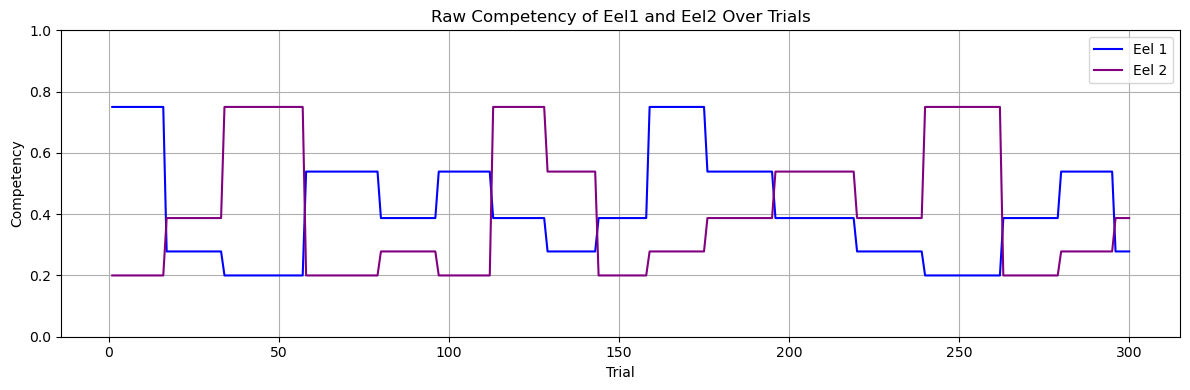

In [12]:
# (1) y축이 0~1로 설정해서 eel1과 eel2의 Raw competency를 수치로 각각 나타내기

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
plt.plot(df["trial_idx"], df["eel1_competency"], label="Eel 1", color="blue")
plt.plot(df["trial_idx"], df["eel2_competency"], label="Eel 2", color="purple")
plt.xlabel("Trial")
plt.ylabel("Competency")
plt.title("Raw Competency of Eel1 and Eel2 Over Trials")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


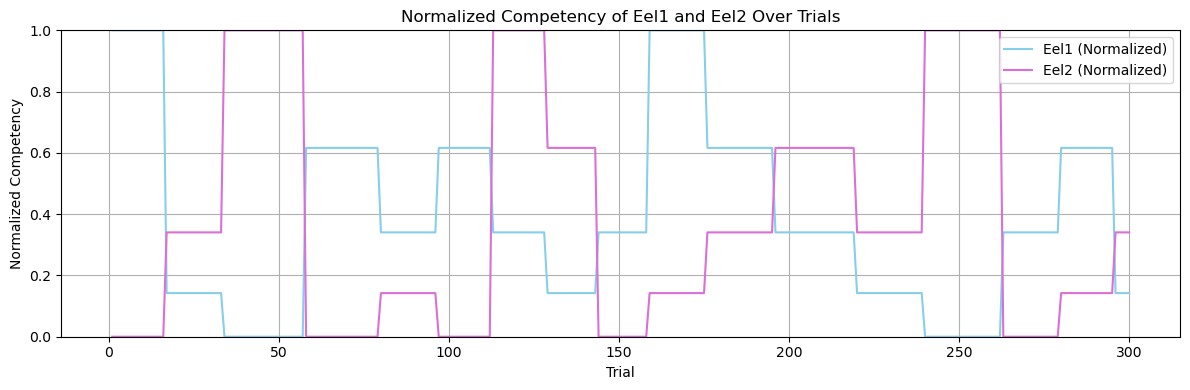

In [16]:
# (2) y축을 0~1로 설정해서 eel1과 eel2의 competency를 normalized해서 나타내기

from sklearn.preprocessing import MinMaxScaler

# 각 열을 0~1로 정규화
scaler = MinMaxScaler()
df[["eel1_norm", "eel2_norm"]] = scaler.fit_transform(df[["eel1_competency", "eel2_competency"]])

plt.figure(figsize=(12, 4))
plt.plot(df["trial_idx"], df["eel1_norm"], label="Eel1 (Normalized)", color="skyblue")
plt.plot(df["trial_idx"], df["eel2_norm"], label="Eel2 (Normalized)", color="orchid")
plt.xlabel("Trial")
plt.ylabel("Normalized Competency")
plt.title("Normalized Competency of Eel1 and Eel2 Over Trials")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


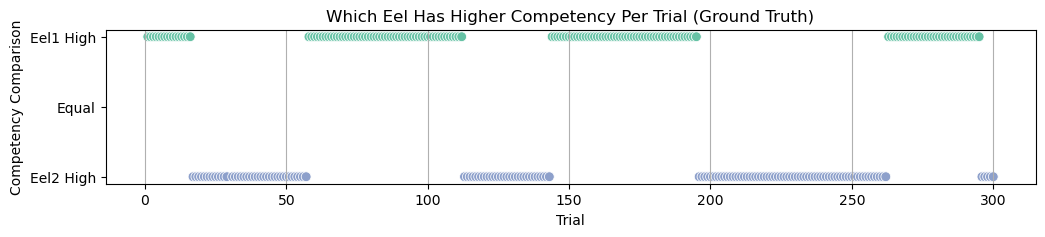

In [18]:
# (3) y축을 high, low로 설정해서 eel1과 eel2를 비교했을 때 뭐가 high, low인지 나타내기 (Categorical)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# eel1과 eel2의 competency 비교 결과 계산
df["competency_diff"] = np.sign(df["eel1_competency"] - df["eel2_competency"])
df["competency_label"] = df["competency_diff"].map({1: "Eel1 High", -1: "Eel2 High", 0: "Equal"})

# y축 순서 지정
order = ["Eel1 High", "Equal", "Eel2 High"]
df["competency_label"] = pd.Categorical(df["competency_label"], categories=order, ordered=True)

# 시각화
plt.figure(figsize=(12, 2))
sns.scatterplot(x="trial_idx", y="competency_label", data=df, hue="competency_label", palette="Set2", s=50, legend=False)
plt.title("Which Eel Has Higher Competency Per Trial (Ground Truth)")
plt.xlabel("Trial")
plt.ylabel("Competency Comparison")
plt.yticks(order)
plt.grid(True, axis='x')
# plt.tight_layout()
plt.show()



In [40]:
df

,trial_idx,n1,n2,reward,eel1_reliability,eel2_reliability,eel1_competency,eel2_competency,reported_reliability,reported_competency,target_eel_idx
0,1,2,0,True,0.25,0.1,0.750000,0.200000,1,0,1
1,2,3,0,True,0.25,0.1,0.750000,0.200000,1,1,2
2,3,3,0,True,0.25,0.1,0.750000,0.200000,1,1,1
3,4,3,0,False,0.25,0.1,0.750000,0.200000,1,1,1
4,5,3,0,True,0.25,0.1,0.750000,0.200000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
294,296,1,0,False,0.25,0.1,0.278316,0.387298,1,1,2
295,297,0,2,False,0.25,0.1,0.278316,0.387298,0,0,1
296,298,0,3,False,0.25,0.1,0.278316,0.387298,0,0,2
297,299,2,0,False,0.25,0.1,0.278316,0.387298,0,0,2


### 2) Reported Competency?

##### Only Reported Competency

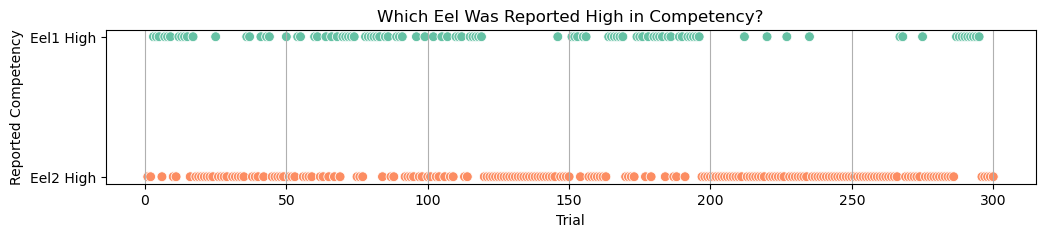

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# (가정) df 에는 ['trial_idx','reported_competency','target_eel_idx'] 컬럼이 있습니다.

# 1) 조건에 맞춰 'Eel1 High' / 'Eel2 High' 레이블 생성
cond = (
    ((df['reported_competency'] == 1) & (df['target_eel_idx'] == 1)) |
    ((df['reported_competency'] == 0) & (df['target_eel_idx'] == 2))
)
df['reported_competency_label'] = np.where(cond, 'Eel1 High', 'Eel2 High')

# 2) 카테고리형으로 순서 고정
order = ['Eel1 High', 'Eel2 High']
df['reported_competency_label'] = pd.Categorical(
    df['reported_competency_label'],
    categories=order,
    ordered=True
)

# 3) 시각화
plt.figure(figsize=(12,2))
sns.scatterplot(
    x='trial_idx',
    y='reported_competency_label',
    data=df,
    hue='reported_competency_label',
    palette='Set2',
    s=50,
    legend=False
)
plt.yticks(order)
plt.xlabel('Trial')
plt.ylabel('Reported Competency')
plt.title('Which Eel Was Reported High in Competency?')
plt.grid(True, axis='x')
plt.show()


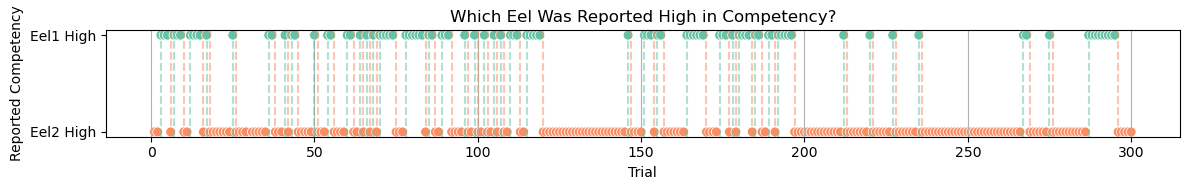

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# (가정) df에는 ['trial_idx','reported_competency','target_eel_idx'] 컬럼이 있습니다.

# 1) 'Eel1 High' / 'Eel2 High' 레이블 생성
cond = (
    ((df['reported_competency'] == 1) & (df['target_eel_idx'] == 1)) |
    ((df['reported_competency'] == 0) & (df['target_eel_idx'] == 2))
)
df['reported_competency_label'] = np.where(cond, 'Eel1 High', 'Eel2 High')

# 2) 카테고리형으로 순서 고정
order = ['Eel1 High', 'Eel2 High']
df['reported_competency_label'] = pd.Categorical(
    df['reported_competency_label'],
    categories=order,
    ordered=True
)

# 3) 판단 변화 지점 탐지
label_changes = df['reported_competency_label'].ne(df['reported_competency_label'].shift())
change_points = df.loc[label_changes & (df.index > 0), 'trial_idx'].values
change_directions = df.loc[label_changes & (df.index > 0), 'reported_competency_label'].values

# 4) 시각화
plt.figure(figsize=(12, 2))
ax = sns.scatterplot(
    x='trial_idx',
    y='reported_competency_label',
    data=df,
    hue='reported_competency_label',
    palette='Set2',
    s=50,
    legend=False
)

# 5) 세로선 추가: 방향에 따라 색상 지정
for trial, label in zip(change_points, change_directions):
    color = sns.color_palette('Set2')[0] if label == 'Eel1 High' else sns.color_palette('Set2')[1]
    plt.axvline(x=trial, color=color, alpha=0.5, linestyle='--')

# 6) 마무리 설정
plt.yticks(order)
plt.xlabel('Trial')
plt.ylabel('Reported Competency')
plt.title('Which Eel Was Reported High in Competency?')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


##### Ground Truth vs. Reported Competency

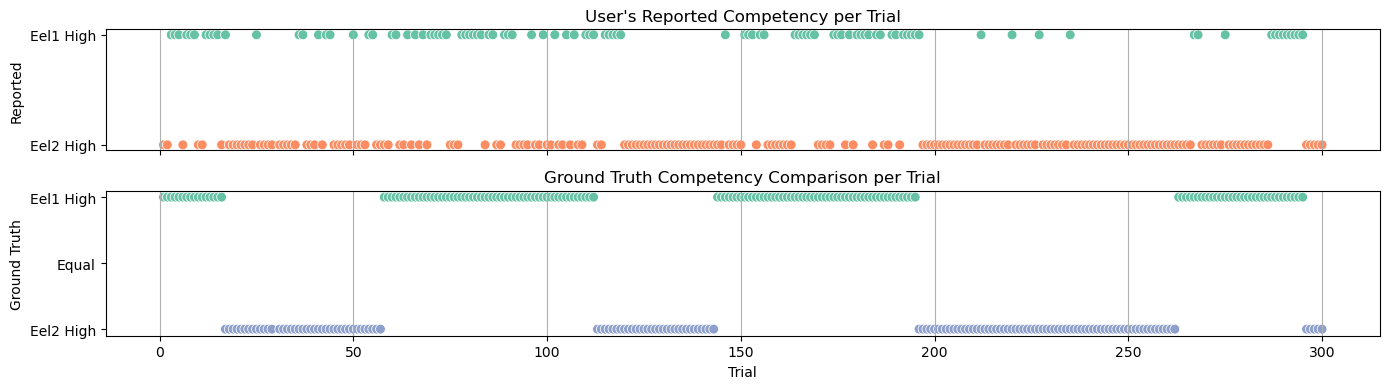

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# competency ground truth 비교
df["competency_diff"] = np.sign(df["eel1_competency"] - df["eel2_competency"])
df["competency_label"] = df["competency_diff"].map({1: "Eel1 High", -1: "Eel2 High", 0: "Equal"})

# y축 순서 지정
cat_order = ["Eel1 High", "Equal", "Eel2 High"]

# Ground truth competency label
df["competency_label"] = pd.Categorical(df["competency_label"], categories=cat_order, ordered=True)

# 사용자 report 기반 판단
cond = (
    ((df['reported_competency'] == 1) & (df['target_eel_idx'] == 1)) |
    ((df['reported_competency'] == 0) & (df['target_eel_idx'] == 2))
)
df['reported_competency_label'] = np.where(cond, 'Eel1 High', 'Eel2 High')
df['reported_competency_label'] = pd.Categorical(df['reported_competency_label'], categories=["Eel1 High", "Eel2 High"], ordered=True)

# figure 준비
fig, axes = plt.subplots(2, 1, figsize=(14, 4), sharex=True, height_ratios=[1, 1.2])

# (1) 위쪽: 사용자 주관적 판단
sns.scatterplot(
    ax=axes[0],
    x='trial_idx',
    y='reported_competency_label',
    data=df,
    hue='reported_competency_label',
    palette='Set2',
    s=50,
    legend=False
)
axes[0].set_yticks(["Eel1 High", "Eel2 High"])
axes[0].set_ylabel("Reported")
axes[0].set_title("User's Reported Competency per Trial")
axes[0].grid(True, axis='x')

# (2) 아래쪽: ground truth
sns.scatterplot(
    ax=axes[1],
    x='trial_idx',
    y='competency_label',
    data=df,
    hue='competency_label',
    palette='Set2',
    s=50,
    legend=False
)
axes[1].set_yticks(cat_order)
axes[1].set_ylabel("Ground Truth")
axes[1].set_xlabel("Trial")
axes[1].set_title("Ground Truth Competency Comparison per Trial")
axes[1].grid(True, axis='x')

plt.tight_layout()
plt.show()


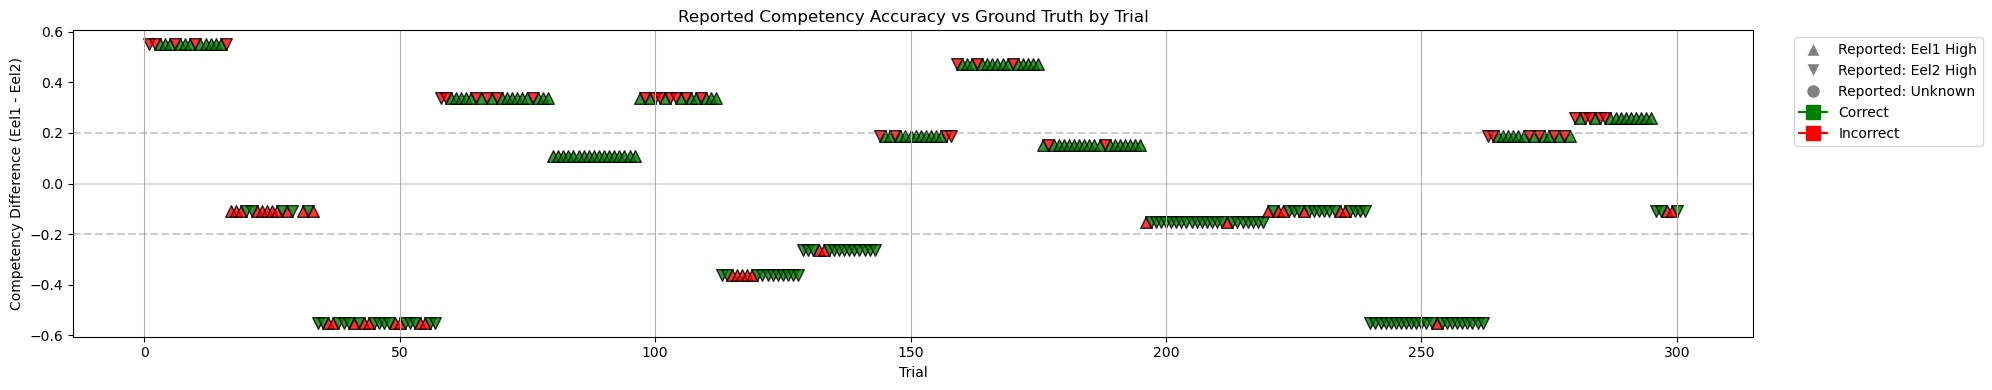

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# competency 차이 및 정답 여부 계산
df['competency_diff'] = df['eel1_competency'] - df['eel2_competency']
df['abs_diff'] = np.abs(df['competency_diff'])

# ground truth label
df['gt_label'] = np.select(
    [df['competency_diff'] > 0, df['competency_diff'] < 0, df['competency_diff'] == 0],
    ['Eel1 High', 'Eel2 High', 'Equal'],
    default='Unknown'
)

# 사용자 판단 label
df['reported_label'] = np.select(
    [((df['reported_competency'] == 1) & (df['target_eel_idx'] == 1)) | ((df['reported_competency'] == 0) & (df['target_eel_idx'] == 2)),
     ((df['reported_competency'] == 1) & (df['target_eel_idx'] == 2)) | ((df['reported_competency'] == 0) & (df['target_eel_idx'] == 1))],
    ['Eel1 High', 'Eel2 High'],
    default='Unknown'
)

# 정답 여부
df['correct'] = (df['reported_label'] == df['gt_label'])

# 마커 모양 지정
df['marker'] = df['reported_label'].map({
    'Eel1 High': '^',
    'Eel2 High': 'v',
    'Unknown': 'o'
})

# 색상 지정
df['color'] = df['correct'].map({True: 'green', False: 'red'})

# 시각화
plt.figure(figsize=(20, 4))
for i, row in df.iterrows():
    plt.scatter(
        # row['trial_idx'], row['abs_diff'],
        row['trial_idx'], row['competency_diff'],
        color=row['color'],
        marker=row['marker'],
        s=70,
        alpha=0.8,
        edgecolors='k'
    )

# 보조 선 추가 (예: 확실성 기준선)
plt.axhline(0.2, color='gray', linestyle='--', alpha=0.4)
plt.axhline(0, color='darkgray', linestyle='-', alpha=0.4)
plt.axhline(-0.2, color='gray', linestyle='--', alpha=0.4)

# 범례 수동 작성
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='^', color='w', label='Reported: Eel1 High', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='v', color='w', label='Reported: Eel2 High', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Reported: Unknown', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='s', color='green', label='Correct', markersize=10),
    Line2D([0], [0], marker='s', color='red', label='Incorrect', markersize=10)
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left')

plt.xlabel("Trial")
# plt.ylabel("Competency Difference (|Eel1 - Eel2|)")
plt.ylabel("Competency Difference (Eel1 - Eel2)")
plt.title("Reported Competency Accuracy vs Ground Truth by Trial")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [43]:
# Unknown이 발생한 trial 살펴보기 -> 없어야 맞음
unknown_df = df[df['reported_label'] == 'Unknown'][['trial_idx', 'reported_competency', 'target_eel_idx', 'gt_label', 'reported_label']]

if len(unknown_df) == 0:
    print("No unknown")
else: 
    print(unknown_df)

No unknown


##### (A) 누적 정답률 Plot (누적 정답 / 진행 trial 수)

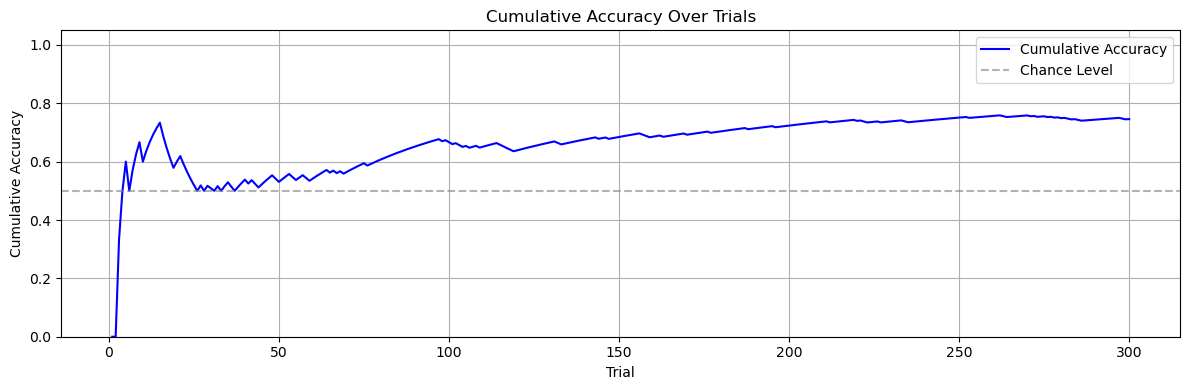

In [45]:
df['cumulative_correct'] = df['correct'].cumsum()
df['cumulative_accuracy'] = df['cumulative_correct'] / (df.index + 1)

plt.figure(figsize=(12,4))
plt.plot(df['trial_idx'], df['cumulative_accuracy'], label='Cumulative Accuracy', color='blue')
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.6, label='Chance Level')
plt.xlabel("Trial")
plt.ylabel("Cumulative Accuracy")
plt.title("Cumulative Accuracy Over Trials")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


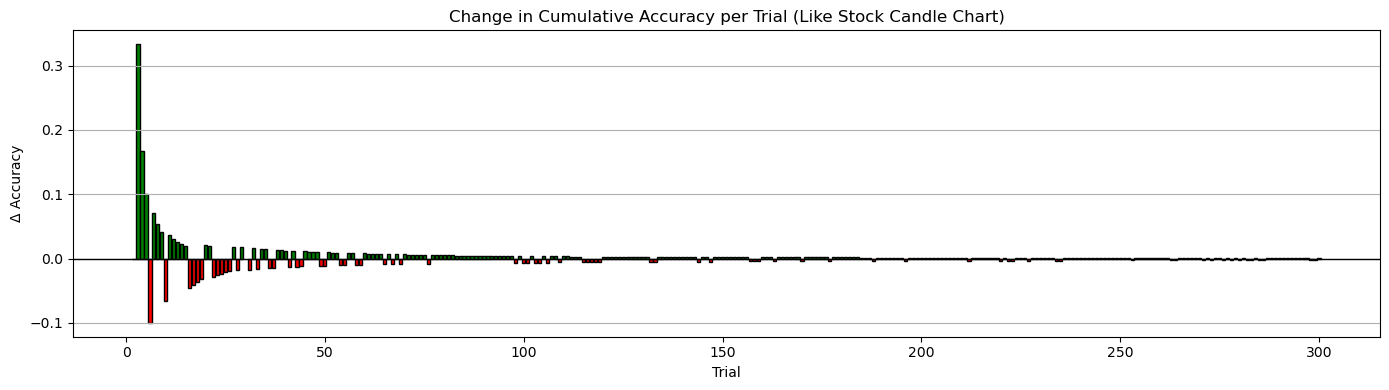

In [48]:
# 누적 정확도 계산
df['cumulative_correct'] = df['correct'].cumsum()
df['cumulative_accuracy'] = df['cumulative_correct'] / (df.index + 1)
df['cumulative_accuracy_shifted'] = df['cumulative_accuracy'].shift(1)
df['delta_accuracy'] = df['cumulative_accuracy'] - df['cumulative_accuracy_shifted']

# 증감 색상: 증가면 초록, 감소면 빨강
df['delta_color'] = df['delta_accuracy'].apply(lambda x: 'green' if x > 0 else ('red' if x < 0 else 'gray'))

# 막대그래프 그리기
plt.figure(figsize=(14, 4))
plt.bar(df['trial_idx'], df['delta_accuracy'], color=df['delta_color'], edgecolor='black', width=0.8)
plt.axhline(0, color='black', linewidth=1)
plt.title("Change in Cumulative Accuracy per Trial (Like Stock Candle Chart)")
plt.xlabel("Trial")
plt.ylabel("Δ Accuracy")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


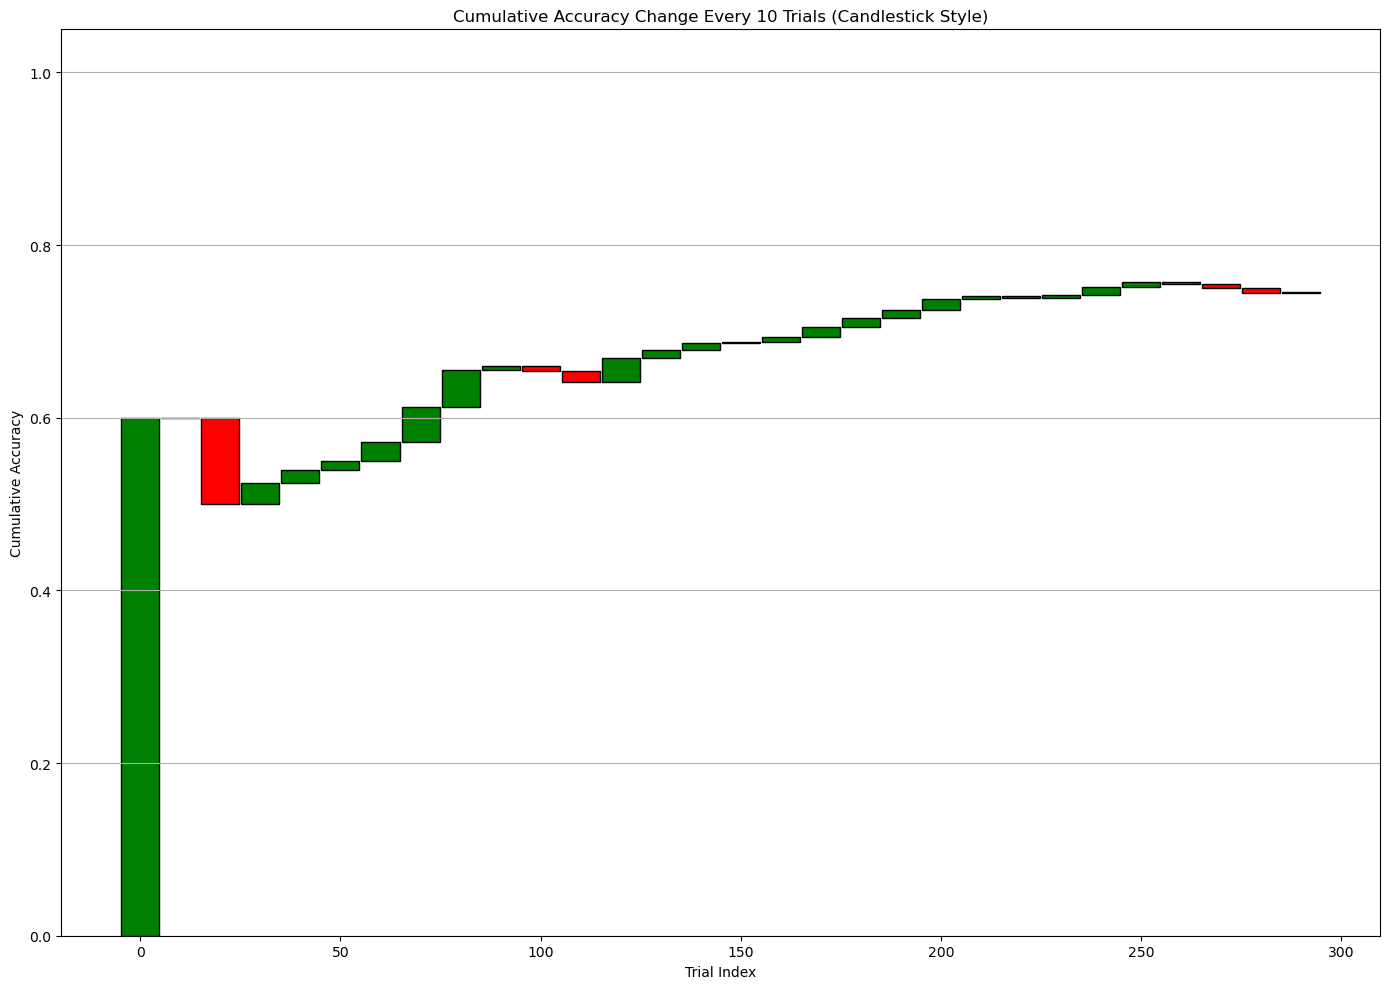

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# 누적 정답 수 및 정확도 계산
df['cumulative_correct'] = df['correct'].cumsum()
df['cumulative_accuracy'] = df['cumulative_correct'] / (df.index + 1)

# 몇 개씩 묶을 것인지 설정
step = 10
n = len(df)
segment_start_idxs = list(range(0, n, step))

bars = []

for i, start in enumerate(segment_start_idxs):
    end = min(start + step, n)
    # 해당 구간의 마지막 누적 정확도
    acc_end = df.loc[end - 1, 'cumulative_accuracy']
    
    # 시작 누적 정확도 (구간 시작 전 trial의 누적값)
    if start == 0:
        acc_start = 0
    else:
        acc_start = df.loc[start - 1, 'cumulative_accuracy']
    
    change = acc_end - acc_start
    color = 'green' if change >= 0 else 'red'
    
    bars.append({
        'x': start,
        'width': step,
        'acc_start': acc_start,
        'acc_end': acc_end,
        'height': acc_end - acc_start,
        'color': color
        })

# 시각화
plt.figure(figsize=(14, 10))

for bar in bars:
    plt.bar(
        bar['x'], bar['height'],
        width=bar['width'] * 0.95,
        bottom=bar['acc_start'],
        color=bar['color'],
        align='center',
        edgecolor='black'
    )

plt.xlabel("Trial Index")
plt.ylabel("Cumulative Accuracy")
plt.title(f"Cumulative Accuracy Change Every {step} Trials (Candlestick Style)")
plt.ylim(0, 1.05)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


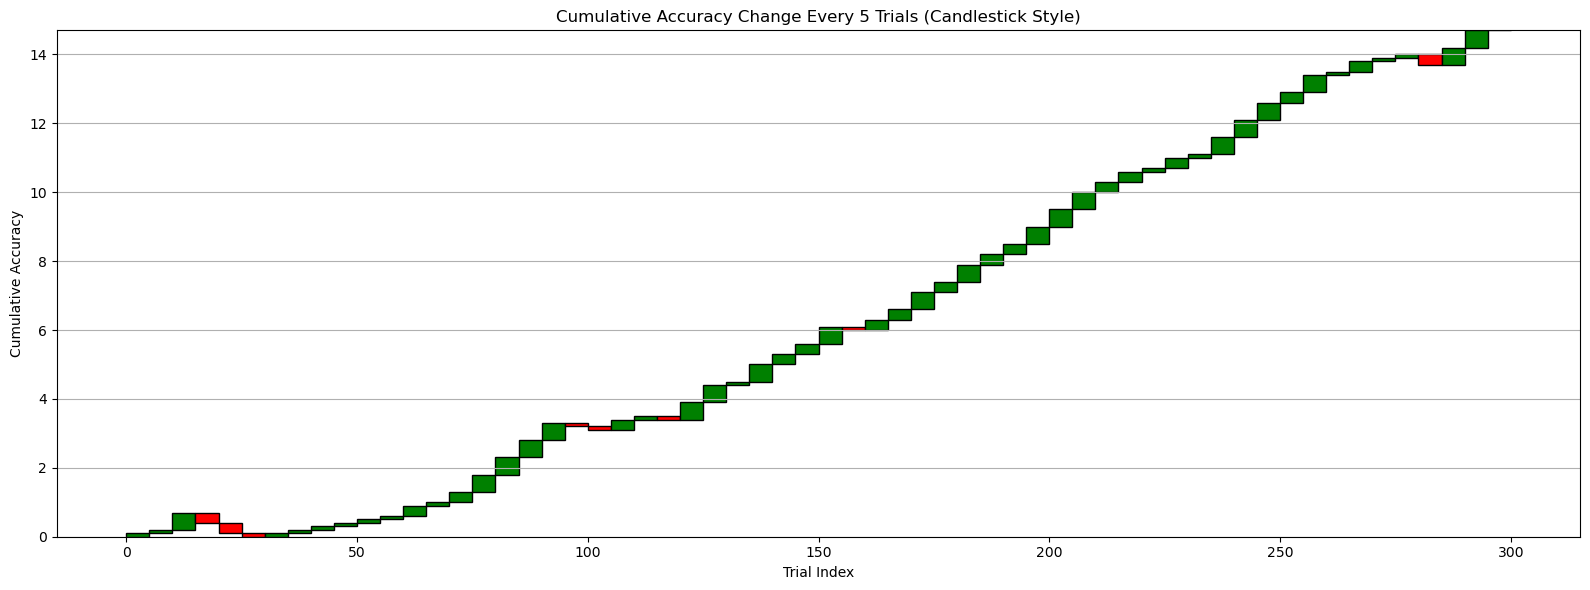

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# 누적 정확도 및 step size
step_size = 5
bars = []

# 초기 값
start_acc = 0.0
start_x = 0

# 누적 정확도 기반 막대 계산
for i in range(0, len(df), step_size):
    end_x = start_x + step_size
    corrects = df.iloc[i:i+step_size]['correct']
    
    if len(corrects) == 0:
        continue
    
    step_acc = corrects.mean()
    end_acc = start_acc + (step_acc - 0.5)  # 예: 평균이 0.6이면 0.1 상승
    height = end_acc - start_acc
    
    color = 'green' if height >= 0 else 'red'
    
    bars.append({
        'x': start_x,
        'width': step_size,
        'acc_start': start_acc,
        'height': height,
        'color': color
    })
    
    # 다음 시작점 갱신
    start_acc = end_acc
    start_x = end_x  # 다음 막대 시작점은 현재 끝점

# 시각화
plt.figure(figsize=(16, 6))
for bar in bars:
    plt.bar(
        bar['x'], bar['height'],
        width=bar['width'],
        bottom=bar['acc_start'],
        color=bar['color'],
        edgecolor='black',
        align='edge'  # 'edge'를 그대로 사용하되 간격을 정확히 붙임
    )

plt.xlabel("Trial Index")
plt.ylabel("Cumulative Accuracy")
plt.title("Cumulative Accuracy Change Every 5 Trials (Candlestick Style)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


##### (B) 정확/오답 개수 누적 막대 그래프

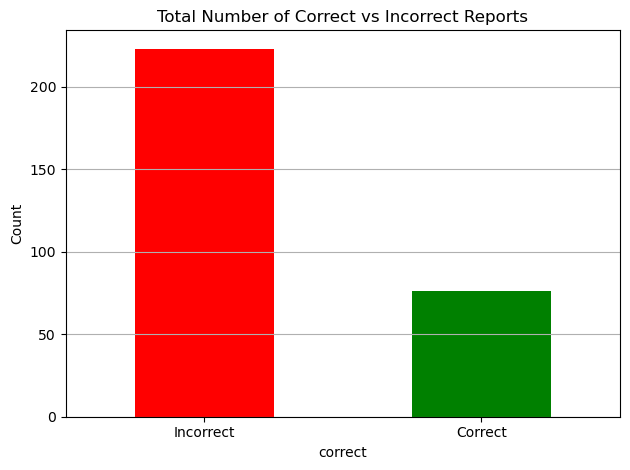

In [46]:
correct_count = df['correct'].value_counts()
correct_count.plot(kind='bar', color=['red', 'green'], rot=0)
plt.xticks([0, 1], ['Incorrect', 'Correct'])
plt.title("Total Number of Correct vs Incorrect Reports")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


##### (C) competency 차이(|diff|)에 따른 정답 확률 히트맵/라인 그래프

/var/folders/c7/kg6tjj2s1sl991q596nkz6900000gn/T/ipykernel_21733/3016130682.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_accuracy = df.groupby('bin_center')['correct'].mean().reset_index()


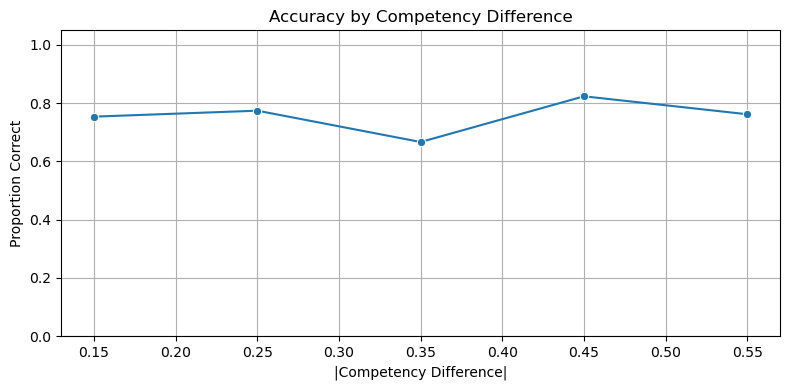

In [50]:
df['diff_bin'] = pd.cut(df['abs_diff'], bins=np.linspace(0, 1, 11))
df['bin_center'] = df['diff_bin'].apply(lambda x: x.mid)  # 중간값 추출

bin_accuracy = df.groupby('bin_center')['correct'].mean().reset_index()

plt.figure(figsize=(8,4))
sns.lineplot(data=bin_accuracy, x='bin_center', y='correct', marker='o')
plt.ylim(0, 1.05)
plt.title("Accuracy by Competency Difference")
plt.ylabel("Proportion Correct")
plt.xlabel("|Competency Difference|")
plt.grid(True)
plt.tight_layout()
plt.show()


### 3) Bayesian Competency

> 질문: 각 eel의 실제 competency가 15–18번 Trial 주기로 바뀔 때, 사용자가 그 변화를 학습하여 ‘지금 더 잘 잡히는(eel의 θ가 높은) eel’ 쪽에서 물고기를 더 많이 잡도록 선택·행동했는가?

각 사후평균(mean1, mean2)은 “해당 시점까지 관찰된 물고기 잡은 개수에 근거해, 각 eel의 진짜 성공확률 θ를 가장 그럴듯하게 추정한 값”
* mean1 > mean2 = **eel1의 competency θ₁**을 eel2의 θ₂보다 높게 평가하고 있다
* mean1 < mean2 = eel1의 competency θ₁보다 **eel2의 θ₂**를 높게 평가하고 있다

In [ ]:
import pandas as pd

# ——— 1) 사전 설정 ———
# df: 이전에 생성한 DataFrame (cols: 'trial_idx','n1','n2', ...)
# uninformative prior: Beta(1,1)
    # alpha = the cumulative number of catched fish (e.g. n1)
    # beta  = the cumulative number of missed fish (e.g. 6(=total) - n1)
alpha1, beta1 = 1.0, 1.0
alpha2, beta2 = 1.0, 1.0

# 결과 저장을 위한 리스트
posterior_records = []

# ——— 2) 각 trial별로 업데이트 ———
for _, row in df.iterrows():
    n1, n2 = row['n1'], row['n2']
    
    # eel1 업데이트
    alpha1 += n1
    beta1  += 6 - n1
    
    # eel2 업데이트
    alpha2 += n2
    beta2  += 6 - n2
    
    # 사후 파라미터와 사후평균 저장
    posterior_records.append({
        'trial': row['trial_idx'],
        'alpha1': alpha1,            # eel1 posterior α
        'beta1':  beta1,             # eel1 posterior β
        'mean1':  alpha1/(alpha1+beta1),
        'alpha2': alpha2,            # eel2 posterior α
        'beta2':  beta2,             # eel2 posterior β
        'mean2':  alpha2/(alpha2+beta2),
    })

    df.append({
        'mean1'
    })

# ——— 3) DataFrame으로 변환 및 확인 ———
post_df = pd.DataFrame(posterior_records)
print(post_df.tail(10))  # 첫 10개 trial의 사후 분포 파라미터 및 평균 출력


     trial  alpha1   beta1     mean1  alpha2   beta2     mean2
289    291   388.0  1354.0  0.222732   312.0  1430.0  0.179104
290    292   391.0  1357.0  0.223684   312.0  1436.0  0.178490
291    293   394.0  1360.0  0.224629   312.0  1442.0  0.177879
292    294   397.0  1363.0  0.225568   312.0  1448.0  0.177273
293    295   400.0  1366.0  0.226501   312.0  1454.0  0.176670
294    296   401.0  1371.0  0.226298   312.0  1460.0  0.176072
295    297   401.0  1377.0  0.225534   314.0  1464.0  0.176603
296    298   401.0  1383.0  0.224776   317.0  1467.0  0.177691
297    299   403.0  1387.0  0.225140   317.0  1473.0  0.177095
298    300   403.0  1393.0  0.224388   317.0  1479.0  0.176503


#### 그래프

In [70]:
# 비교분석 = 추정치 차이(mean1−mean2) vs. 실제 잡힌 물고기 차이(n1−n2)
# 검증 = 상관분석 또는 창(window)별 평균 비교를 통해 “학습→선택→성과”의 일관성을 평가

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# ——— 0) 전제: df와 post_df가 이미 메모리에 로드되어 있다고 가정 ———
# df: ['trial_idx','n1','n2', ...]
# post_df: ['trial','mean1','mean2', ...]

# ——— 1) df와 post_df 병합 ———
merged = pd.merge(
    df[['trial_idx', 'n1', 'n2']],
    post_df[['trial', 'mean1', 'mean2']],
    left_on='trial_idx',
    right_on='trial'
)

# ——— 2) Δmean, Δcatch 계산 ———
merged['delta_mean']  = merged['mean1']  - merged['mean2']
merged['delta_catch'] = merged['n1']     - merged['n2']

##### Pearson 상관계수 계산

In [71]:
# ——— 3) Pearson 상관계수 계산 ———
# Pearson 상관계수를 통해 Δmean과 Δcatch의 관계 강도를 정량화
rho, pval = pearsonr(merged['delta_mean'], merged['delta_catch'])
print(f"Pearson correlation: ρ = {rho:.3f}, p = {pval:.3f}")

# ——— 4) Posterior mean 추이 시계열 ———
# plt.figure(figsize=(8, 3))
# plt.plot(merged['trial_idx'], merged['mean1'], label='Eel1 Mean')
# plt.plot(merged['trial_idx'], merged['mean2'], label='Eel2 Mean')
# plt.xlabel('Trial')
# plt.ylabel('Posterior Mean')
# plt.title('Eel Competency Estimates Over Trials')
# plt.legend()
# plt.tight_layout()
# plt.show()



Pearson correlation: ρ = 0.160, p = 0.005


##### Posterior mean 추이 시계열

> 사후평균 추이 시계열로 각 eel competency 추정 변화를 확인

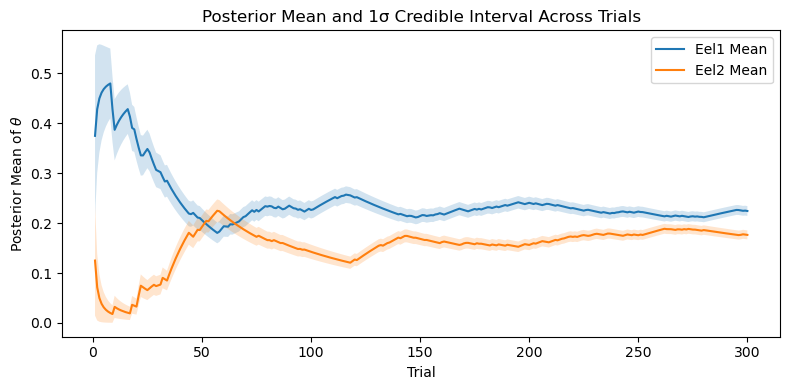

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ——— 1) 분산 계산 및 추가 ———
# Beta 분포 분산: αβ / [ (α+β)^2 (α+β+1) ]
post_df['var1'] = (
    post_df['alpha1'] * post_df['beta1']
    / ((post_df['alpha1'] + post_df['beta1'])**2 * (post_df['alpha1'] + post_df['beta1'] + 1))
)
post_df['var2'] = (
    post_df['alpha2'] * post_df['beta2']
    / ((post_df['alpha2'] + post_df['beta2'])**2 * (post_df['alpha2'] + post_df['beta2'] + 1))
)

# (선택) 표준편차도 계산해두면 시각화할 때 편리합니다.
post_df['std1'] = np.sqrt(post_df['var1'])
post_df['std2'] = np.sqrt(post_df['var2'])

# ——— 2) 사후평균 선형 플롯 + 불확실성 표시 ———
plt.figure(figsize=(8, 4))
# Eel1
plt.plot(post_df['trial'], post_df['mean1'], label='Eel1 Mean')
plt.fill_between(
    post_df['trial'],
    post_df['mean1'] - post_df['std1'],
    post_df['mean1'] + post_df['std1'],
    alpha=0.2
)
# Eel2
plt.plot(post_df['trial'], post_df['mean2'], label='Eel2 Mean')
plt.fill_between(
    post_df['trial'],
    post_df['mean2'] - post_df['std2'],
    post_df['mean2'] + post_df['std2'],
    alpha=0.2
)

plt.xlabel('Trial')
plt.ylabel(r'Posterior Mean of $\theta$')
plt.title('Posterior Mean and 1σ Credible Interval Across Trials')
plt.legend()
plt.tight_layout()
plt.show()


##### Δmean vs Δcatch 산점도 + 회귀선
> 산점도와 회귀선으로 “추정치 차이가 클수록 행동 차이도 커지는지” 시각화
* delta mean > 0 = higher delta, more preferring **eel1** because the learner thinks **eel1's competency is higher**
* delta mean < 0 = lower delta, more preferring **eel2** because the learner thinks **eel2's competency is higher**


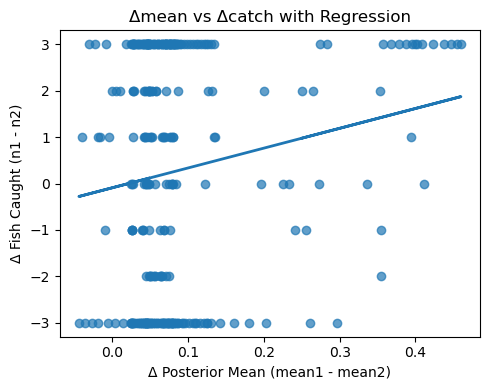

In [72]:
# ——— Δmean vs Δcatch 산점도 + 회귀선 ——— 
X = merged['delta_mean'].values.reshape(-1, 1)
y = merged['delta_catch'].values
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

plt.figure(figsize=(5, 4))
plt.scatter(merged['delta_mean'], merged['delta_catch'], alpha=0.7)
plt.plot(merged['delta_mean'], y_pred, linewidth=2)
plt.xlabel('Δ Posterior Mean (mean1 - mean2)')
plt.ylabel('Δ Fish Caught (n1 - n2)')
plt.title('Δmean vs Δcatch with Regression')
plt.tight_layout()
plt.show()

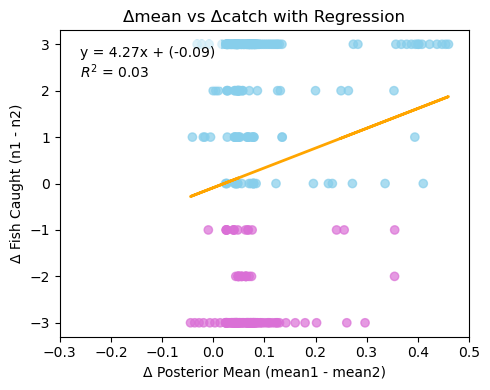

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ——— 데이터 및 모델 준비 (merged DataFrame 필요) ———
X = merged['delta_mean'].values.reshape(-1, 1)
y = merged['delta_catch'].values
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# 회귀식 및 결정계수 계산
coef = model.coef_[0]
intercept = model.intercept_
r2 = model.score(X, y)

# 포인트 색상: Δcatch < 0 → 보라색, Δcatch ≥ 0 → 파란색
colors = np.where(merged['delta_catch'] < 0, 'orchid', 'skyblue')

# ——— 플롯 ———
plt.figure(figsize=(5, 4))
plt.scatter(merged['delta_mean'], merged['delta_catch'], c=colors, alpha=0.7)
plt.plot(merged['delta_mean'], y_pred, color='orange', linewidth=2)

plt.xlabel('Δ Posterior Mean (mean1 - mean2)')
plt.ylabel('Δ Fish Caught (n1 - n2)')
plt.title('Δmean vs Δcatch with Regression')
plt.xlim(-0.3, 0.5)
# 회귀식 및 R² 텍스트 표시
eq_text = f'y = {coef:.2f}x + ({intercept:.2f})\n$R^2$ = {r2:.2f}'
plt.text(
    0.05, 0.95, eq_text,
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
)

plt.tight_layout()
plt.show()


##### 주기별 (윈도우 크기=4) 평균 계산 및 시각화
> 윈도우별 평균(4 trial 간격)으로 주기적 학습 추세 비교

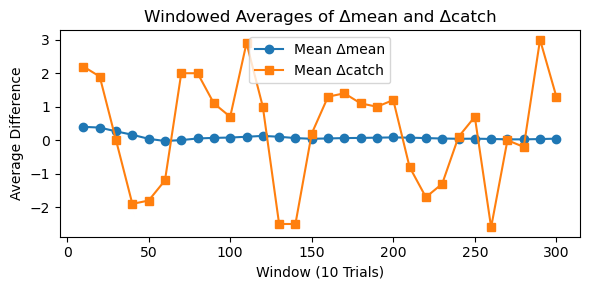

In [67]:
# ——— 6) 주기별 (윈도우 크기=4) 평균 계산 및 시각화 ———
window_step = 10
merged['window'] = ((merged['trial_idx'] - 1) // window_step) + 1
windowed = merged.groupby('window').agg({
    'delta_mean': 'mean',
    'delta_catch': 'mean'
}).reset_index()

plt.figure(figsize=(6, 3))
plt.plot(windowed['window']*window_step, windowed['delta_mean'], marker='o', label='Mean Δmean')
plt.plot(windowed['window']*window_step, windowed['delta_catch'], marker='s', label='Mean Δcatch')
plt.xlabel(f"Window ({window_step} Trials)")
plt.ylabel('Average Difference')
plt.title('Windowed Averages of Δmean and Δcatch')
plt.legend()
plt.tight_layout()
plt.show()
